In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Projects/Level sets

/content/drive/My Drive/Projects/Level sets


In [0]:
%tensorflow_version 1.x

import gc
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import keras.backend as K
import keras.losses

from skimage.draw import random_shapes
from scipy import io
from google.colab.patches import cv2_imshow

from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda
from keras.layers.merge import Concatenate

TensorFlow 1.x selected.


Using TensorFlow backend.


**Data Processing**

*Generate random masks*

In [0]:
def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ) :

    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x

def bwdist(mask):
    return nd.distance_transform_edt(np.logical_not(mask))

def mask2levelSet(mask):
    return bwdist(mask) - bwdist(1 - mask)
    
def grad(x):
    return np.array(np.gradient(x))

In [0]:
dataset = []

In [0]:
reference = []
initializations = []
for file_name in os.listdir('./data/images'):
  index = int(file_name.split('.')[0])
  
  image = cv2.imread(os.path.join('./data/images', file_name), 0)/255.0
  mask = io.loadmat(os.path.join('./data/groundTruth', str(index)+ '.mat'))
  mask = (mask['groundTruth'])[0][0][0][0][0] - 1

  shape = image.shape[:2]
  init, _ = random_shapes(shape, max_shapes=1, shape=None, multichannel=False)
  init = np.where(init == 255, 0, 1)

  phi_i = mask2levelSet(init)
  phi_gt = mask2levelSet(mask)
  F = phi_gt - phi_i
  F = F / np.abs(np.where(F == 0, 1, F)) #prevent division by 0 

  dataset.append([image, phi_i, F])
  reference.append(phi_gt)
  initializations.append(init)

In [0]:
X = []
Y = []

for data in dataset:
  X.append(np.concatenate([np.expand_dims(data[0], -1), np.expand_dims(data[1], -1)], axis = -1))
  Y.append(np.expand_dims(data[2], -1))
  
X = np.asarray(X)
Y = np.asarray(Y)

In [0]:
X.shape, Y.shape

((256, 256, 256, 2), (256, 256, 256, 1))

**Model**

In [0]:
class UNET(object):
  def __init__(self, rows = 512, cols = 512, channels = 4, net_name = 'Unet', lr = 0.0002):
      
      self.input_shape = (rows, cols, channels)
      self.net_name = net_name
      self.history = None
      
      self.model = self.UNet_model()

      self.compile_unet(self.model, lr)
      
  def UNet_model(self, train_bn = True):
      def encode(features_in, filters, kernel_size, batch_normalization = True):
          
          features_out = Conv2D(filters, kernel_size, strides = 2, padding = 'same')(features_in)
          
          if(batch_normalization):
              features_out = BatchNormalization()(features_out, training = train_bn)
          
          features_out = Activation('relu')(features_out)
                      
          return features_out
      
      def decode(features_in, features_conc, filters, kernel_size, batch_normalization = True):
          
          upsampled_features = UpSampling2D(size = (2,2))(features_in)
                      
          concat_features = Concatenate(axis = 3)([features_conc, upsampled_features])
          
          features_out = Conv2D(filters, kernel_size, padding = 'same')(concat_features)
          
          if(batch_normalization):
              features_out = BatchNormalization()(features_out)
          
          features_out = LeakyReLU(alpha = 0.2)(features_out)
          
          return features_out
      
      
      encodings = []
      features_in = Input(shape = self.input_shape)
      
      encodings.append(features_in)
      
      encodings.append(encode(encodings[0], 64, 7, False))
      encodings.append(encode(encodings[1], 128, 5))
      encodings.append(encode(encodings[2], 256, 5))
      encodings.append(encode(encodings[3], 512, 3))
      encodings.append(encode(encodings[4], 512, 3))
      encodings.append(encode(encodings[5], 512, 3))
      encodings.append(encode(encodings[6], 512, 3))
      encodings.append(encode(encodings[7], 512, 3))
  
      
      decode_features = encodings[8]
      
      decode_features = decode(decode_features, encodings[7], 512, 3)
      decode_features = decode(decode_features, encodings[6], 512, 3)
      decode_features = decode(decode_features, encodings[5], 512, 3)
      decode_features = decode(decode_features, encodings[4], 512, 3)
      decode_features = decode(decode_features, encodings[3], 512, 3)
      decode_features = decode(decode_features, encodings[2], 256, 3)
      decode_features = decode(decode_features, encodings[1], 128, 3)
      decode_features = decode(decode_features, encodings[0], 64, 3, False)

      def sigmoid(x):
        return (K.sigmoid(x) * 2) - 1

      output = Conv2D(1, 1, activation = sigmoid, name='output_img')(decode_features)

      model = Model(inputs = [features_in], outputs = output)
      
      return model

  def compile_unet(self, model, lr):
      model.compile(
          optimizer = Adam(lr=lr),
          loss=keras.losses.mean_squared_error
      )
  
  def PSNR(self,y_true, y_pred):
      return - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0)    
  
  def summary(self):
      print(self.model.summary())
      
  def predict(self, sample, **kwargs):
      return self.model.predict(sample, **kwargs)

  def fit(self, X, Y, epochs):
      self.history = self.model.fit(X, Y, batch_size=32, epochs=epochs, verbose=1)
  
  def load(self, filepath, train_bn = True, lr=10e-3):

      self.model = self.UNet_model(train_bn)
      self.compile_unet(self.model, lr) 

      epoch = int(os.path.basename(filepath).split('-')[0])

      self.current_epoch = epoch

      self.model.load_weights(filepath)
      
  def fit_generator(self, generator, *args, **kwargs):
      self.history = self.model.fit_generator(generator, epochs = self.current_epoch, *args, **kwargs)

  def get_records(self):
      return self.history

  def save(self, path, weights_only = True):
      if(weights_only):
          self.model.save_weights(path)
      else:
          self.model.save(path)


In [0]:
rows, cols = X[0].shape[:2]
unet_model = UNET(rows, cols, 2, lr = 10e-4)

In [0]:
unet_model.load('200-0.016.h5')

In [0]:
unet_model.fit(X, Y, 200)
unet_model.save('{0} loss.h5'.format(np.round(unet_model.history.history['loss'][-1],3)))

from matplotlib import pyplot as plt
plt.plot(unet_model.history.history['loss'])
plt.show()

In [0]:
a = [[[2,2,1],[2,3,4]], [[2,2,1],[2,3,4]]]
np.sum(np.square(a))

76

0


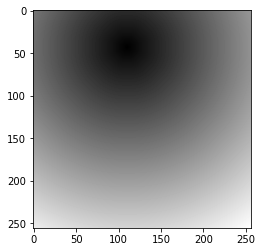

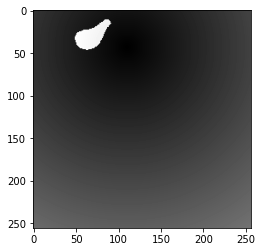

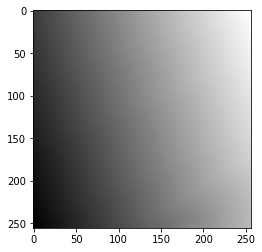

1


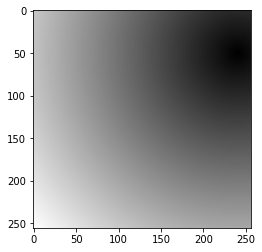

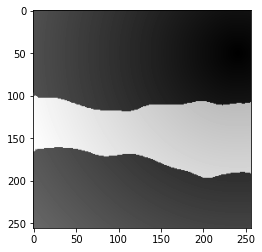

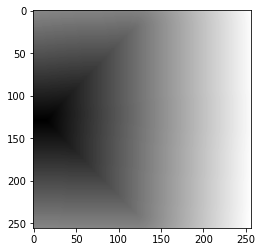

2


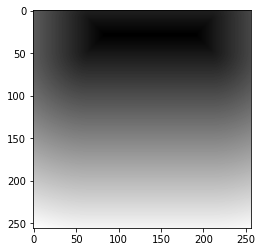

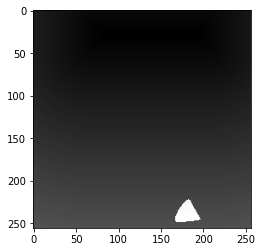

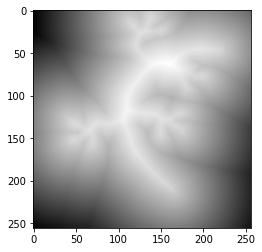

3


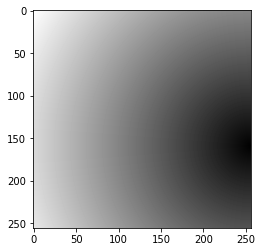

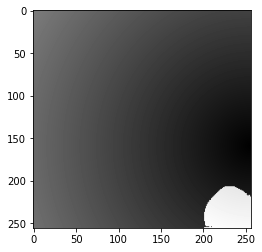

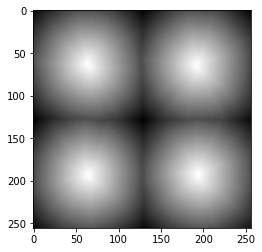

4


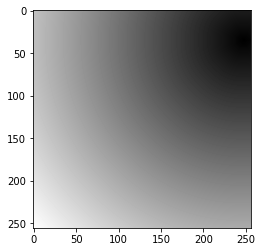

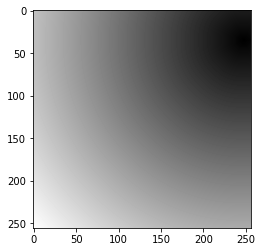

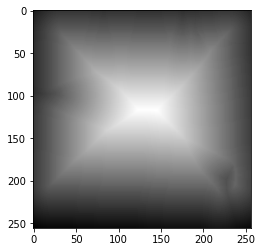

5


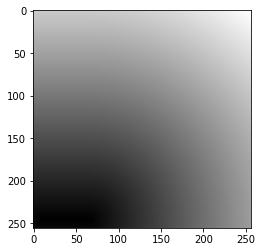

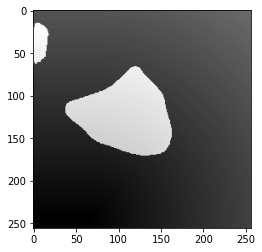

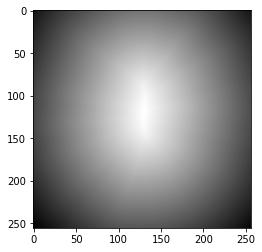

6


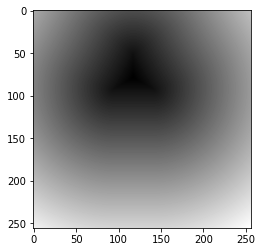

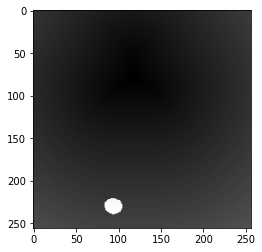

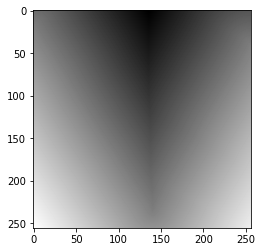

7


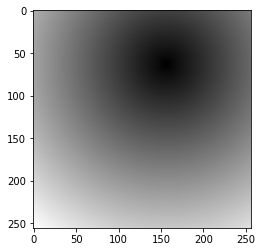

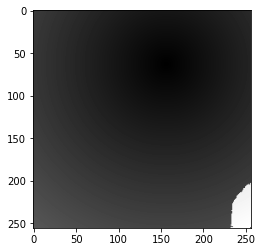

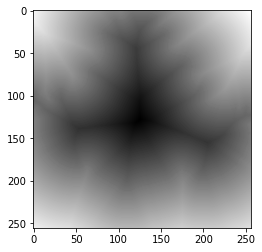

8


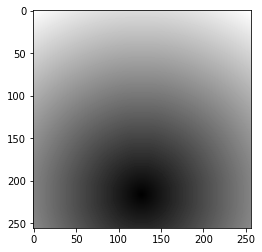

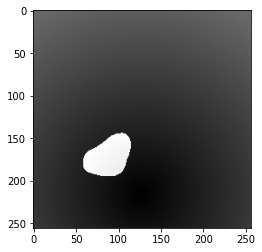

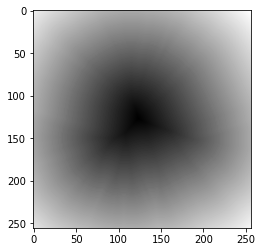

9


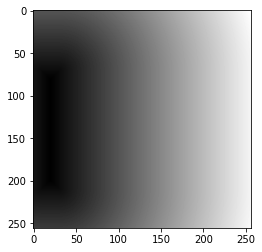

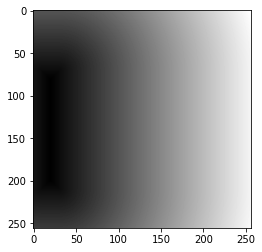

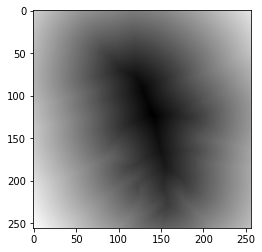

In [0]:
for i in range(10):
  idx = np.random.randint(0, 255, size=1)[0]
  phi = X[idx][:, :,-1]
  print(i)

  dphi = grad(phi)
  dphi_norm = np.sqrt(np.sum(np.square(dphi)))

  
  F = unet_model.predict(np.expand_dims(X[i],axis=0))[0,:,:,0]
  #F = np.where(F<0, -1, +1)

  dphi_t = F * dphi_norm
  phi_t1 = phi + dphi_t

  plt.imshow(phi, cmap='gray')
  plt.show()

  plt.imshow(phi_t1,cmap='gray')
  plt.show()

  plt.imshow(reference[idx],cmap='gray')
  plt.show()

[[[2, 1, 2], [2, 2, 2]], [[3, 1, -1], [2, 2, 2]]]